In [1]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from torchvision.datasets import MNIST
from timeit import default_timer as tdt

from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

C:\Users\seeb\AppData\Local\anaconda3\envs\deep_learning_1\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Choosing a simple problem
# Define the analytical solution u(x, y)
def u(x, y):
    return x**2 + y**2

# Define the source term f(x, y)
def f(X):
    #x = X[:,0]
    #y = X[:,1]
    return -4 * torch.ones_like(X[:,0])

In [3]:
# Illustrating the problem domain
x_min, x_max = 0.0, 3.0
y_min, y_max = 0.0, 4.0
x0 = torch.tensor([x_min, x_max], requires_grad=True)
y0 = torch.tensor([y_min, y_max], requires_grad=True)

u0 = u(x0, y0)

x_lin = torch.linspace(x_min, x_max, 109, requires_grad=True)
y_lin = torch.linspace(y_min, y_max, 100, requires_grad=True)
xv, yv = torch.meshgrid(x_lin, y_lin)
grid_as_2D = torch.column_stack((xv.flatten(), yv.flatten()))

C:\Users\seeb\AppData\Local\anaconda3\envs\deep_learning_1\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
if torch.cuda.is_available():
    my_device = 'cuda'
else:
    my_device = 'cpu'


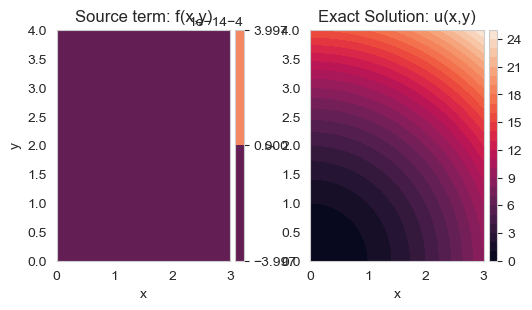

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, figsize=(6,3))
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cnt = ax[0].contourf(xv.detach().numpy(), yv.detach().numpy(), 
                     f(torch.column_stack((xv.flatten(), yv.flatten()))).view(xv.shape[0], xv.shape[1]).detach().numpy(), 
                     levels=25)
fig.colorbar(cnt, cax=cax, orientation='vertical')
ax[0].set_title('Source term: f(x,y)')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_aspect('equal')


divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
cnt = ax[1].contourf(xv.detach().numpy(), yv.detach().numpy(), u(xv, yv).view(xv.shape).detach().numpy(), levels=25)
fig.colorbar(cnt, cax=cax, orientation='vertical')
ax[1].set_title('Exact Solution: u(x,y)')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_aspect('equal')

In [26]:
# Defining the network
class FFN(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size):
        super(FFN, self).__init__()
        
        n_layers = len(hidden_layers_size)
        HL = hidden_layers_size
        
        # Define layers
        self.L1 = nn.Linear(input_size, HL[0], bias=True)
        self.L2 = nn.Linear(HL[0], HL[1], bias=True)
        self.L3 = nn.Linear(HL[1], HL[2], bias=True)
        self.L4 = nn.Linear(HL[2], HL[3], bias=True)
        self.L5 = nn.Linear(HL[3], HL[4], bias=True)
        self.output = nn.Linear(HL[-1], output_size, bias=True)
        
        # Define activation function
        self.act_fn = nn.Tanh()

    def forward(self, x):
        # Hidden layers
        x = self.act_fn(self.L1(x))
        x = self.act_fn(self.L2(x))
        x = self.act_fn(self.L3(x))
        x = self.act_fn(self.L4(x))
        x = self.act_fn(self.L5(x))
        
        # Output layer
        x = self.output(x)
        
        return x

# Define network
net = FFN(2, [256, 256, 256, 256, 256], 1).to(my_device)
x0 = x0.to(my_device)
y0 = y0.to(my_device)

# Print Network shape
print()
print(net.parameters)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



<bound method Module.parameters of FFN(
  (L1): Linear(in_features=2, out_features=256, bias=True)
  (L2): Linear(in_features=256, out_features=256, bias=True)
  (L3): Linear(in_features=256, out_features=256, bias=True)
  (L4): Linear(in_features=256, out_features=256, bias=True)
  (L5): Linear(in_features=256, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=1, bias=True)
  (act_fn): Tanh()
)>


In [27]:
# Define the loss function
def poisson_loss_pde(x, net, using_cuda=False):
    # Ensure that we can compute gradients with respect to the inputs
    #assert x.is_leaf, 'x is not a leaf tensor. Please add requires_grad whereevery its made.'
    
    # Forward pass to get the model prediction
    u = net(x)
    
    # Compute the gradients with respect to the inputs
    grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones(u.size(), device=x.device), create_graph=True)[0]
    
    # Compute the second derivatives (Laplacian of u)
    laplacian_u = 0
    for i in range(x.size(1)):
        grad_u_i = grad_u[:, i:i+1]
        laplacian_u += torch.autograd.grad(grad_u_i, x, grad_outputs=torch.ones(grad_u_i.size(), device=x.device), create_graph=True)[0][:, i:i+1]
    
    # Compute the residuals for the PDE
    pde_residual = ((laplacian_u + f(x)).pow(2)).mean()
    
    return pde_residual

torch_loss = torch.nn.MSELoss()
def poisson_loss_bc(x_bound, net0):
    u0_net = net0(x_bound)
    u0 = u(x_bound[:,0], x_bound[:,1]) # Trying to see if the net can figure out setting 0 on bounds
    u0 = u0.view(-1,1) # Ensure same dimensions for u0_net and u0
    MSE_loss = torch_loss(u0_net, u0)
    return MSE_loss

In [28]:
xx = torch.rand(5,2)
def f(x):
    res = x[:,0] * torch.ones_like(x[:,0])
    res = res.view(-1,1)
    return res
res = poisson_loss_bc(xx, f)
print(res)

tensor(0.0199)


In [29]:
# Test network and loss functions works
# Check the network works
with torch.no_grad():
    inp = torch.Tensor([[1.0, 1.0],
                        [2.0, 2.0],
                        [3.0, 3.0]])
    print(f'input = {inp}')
    print(f'input.shape = {inp.shape}')
    output = net(inp.to(my_device))
    print(f'output = {output}')
    print(f'output.shape = {output.shape}')

input = tensor([[1., 1.],
        [2., 2.],
        [3., 3.]])
input.shape = torch.Size([3, 2])
output = tensor([[0.0231],
        [0.0119],
        [0.0082]])
output.shape = torch.Size([3, 1])


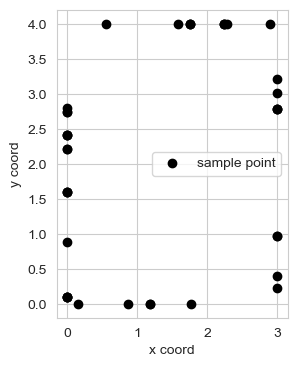

In [30]:
def get_points_on_boundaries(n_points_per_boundary):
    # Method for getting points on the boundary. Assuming a square grid.
    # Left and right boundary
    left = torch.rand(n_points_per_boundary, 2) * y_max + y_min
    left[:,0] = 0.0
    right = torch.rand(n_points_per_boundary, 2) * y_max + y_min
    right[:,0] = x_max
    # Bottom and top boundary
    bottom = torch.rand(n_points_per_boundary, 2) * x_max + x_min
    bottom[:,1] = 0.0
    top = torch.rand(n_points_per_boundary, 2) * x_max + x_min
    top[:,1] = y_max
    # Concatenating them together
    result = torch.cat((bottom, right, top, left), axis=0)
    # Shuffling data. Not sure if this is necesarry
    n_points = 4*n_points_per_boundary
    idx = torch.randint(0, n_points, (n_points,))
    result = result[idx]
    return result

res = get_points_on_boundaries(10)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.scatter(res[:,0], res[:,1], color='k', label='sample point')
ax.set_xlabel('x coord')
ax.set_ylabel('y coord')
ax.set_aspect('equal')
ax.legend()

In [31]:
# Loss saving
loss_saved, pde_res_saved, bc_loss_saved = [], [], []
adapt_pde_loss_saved, adapt_bc_loss_saved = [], []
epochs_saved = []

In [33]:
# Setup optimizer
learning_rate = 3e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)

# SoftAdapt setup
softadapt_obj  = SoftAdapt(beta=0.1)
epochs_to_make_change = 5
adapt_weights = torch.tensor([1,1,1])    # Initial weighting of objects.

# Training setup
num_epochs = 1000
save_every_epochs = 100
batch_size = 64

loss1, loss2 = [], []
net = net.to(my_device)
# Train the model
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    
    # Sample x in the domain. THIS SHOULD BE NORMALIZED TO ZERO MEAN AND UNIT VARIANCE.
    x_y_points = torch.rand(batch_size, 2, device=my_device)   # No gradients needed for input data
    x_y_points[:,0] *= (x0[1] - x0[0])
    x_y_points[:,1] *= (y0[1] - y0[0])
    
    pde_res = poisson_loss_pde(x_y_points, net, True)
    # Sample x on the boundaries.
    x_sample_boundary = get_points_on_boundaries(batch_size).to(my_device)
    bc_loss = poisson_loss_bc(x_sample_boundary, net)
    
    loss1.append( pde_res )
    loss2.append( bc_loss )

    # SoftAdapt
    if epoch % epochs_to_make_change == 0 and epoch != 0:
        adapt_weights = softadapt_obj.get_component_weights(torch.tensor(loss1),
                                                            torch.tensor(loss2),
                                                            verbose=False)
        loss1, loss2 = [], []
    
    loss = adapt_weights[0] * pde_res + adapt_weights[1] * bc_loss #pde_res + bc_loss
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % save_every_epochs == 0 or epoch == 0:
        print(f"Epoch {epoch+1:10d}, Loss: {loss.item():10.5f}, pde_res: {pde_res:11.7f}, bc_loss: {bc_loss:11.7f}, adapt_weights[0]: {adapt_weights[0]:10.5f}, adapt_weights[1]: {adapt_weights[1]:10.5f}")
        epochs_saved.append(epoch+1)
        loss_saved.append(loss.item())
        pde_res_saved.append(pde_res.detach().to('cpu'))
        bc_loss_saved.append(bc_loss.detach().to('cpu'))
        adapt_pde_loss_saved.append( adapt_weights[0]*pde_res.detach().to('cpu') )
        adapt_bc_loss_saved.append( adapt_weights[1]*bc_loss.detach().to('cpu') )


Epoch          1, Loss:    0.42451, pde_res:   0.0884319, bc_loss:   0.3360801, adapt_weights[0]:    1.00000, adapt_weights[1]:    1.00000
Epoch        100, Loss:    0.17961, pde_res:   0.0498424, bc_loss:   0.3115605, adapt_weights[0]:    0.50418, adapt_weights[1]:    0.49582
Epoch        200, Loss:    0.10634, pde_res:   0.0406638, bc_loss:   0.1753978, adapt_weights[0]:    0.51258, adapt_weights[1]:    0.48742
Epoch        300, Loss:    0.11831, pde_res:   0.0967007, bc_loss:   0.1400777, adapt_weights[0]:    0.50181, adapt_weights[1]:    0.49819
Epoch        400, Loss:    0.12289, pde_res:   0.0374131, bc_loss:   0.2074666, adapt_weights[0]:    0.49735, adapt_weights[1]:    0.50265
Epoch        500, Loss:    0.06765, pde_res:   0.0417498, bc_loss:   0.0930567, adapt_weights[0]:    0.49510, adapt_weights[1]:    0.50490
Epoch        600, Loss:    0.06543, pde_res:   0.0609666, bc_loss:   0.0698875, adapt_weights[0]:    0.49924, adapt_weights[1]:    0.50076
Epoch        700, Loss:    

torch.Size([10900])


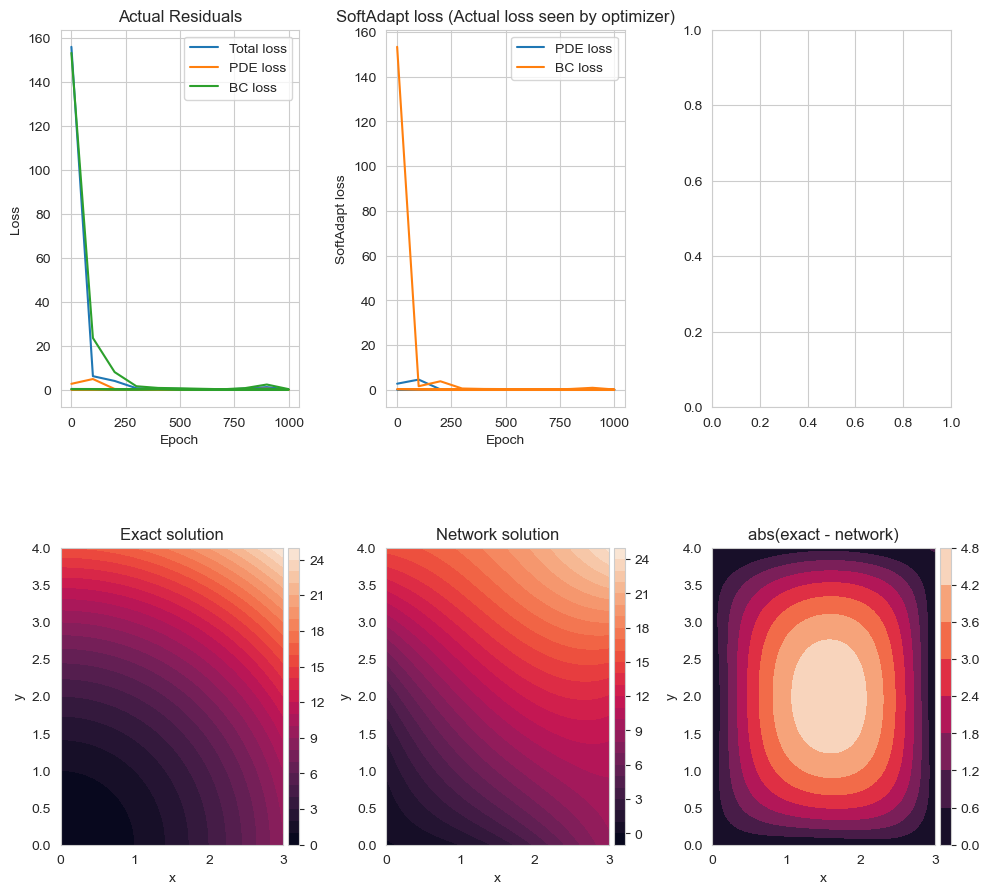

In [34]:
# Exact solution
u_exact = u(xv, yv)

net_cpu = net.to('cpu')
# Getting solution on grid
u_net = net_cpu(grid_as_2D)

x_range = np.arange(0, len(loss_saved)+1, save_every_epochs)
x_range = np.concatenate((np.array([1]), x_range))

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,10), gridspec_kw={'height_ratios': [2, 3]})
ax[0,0].plot(epochs_saved, loss_saved, label='Total loss')
ax[0,0].plot(epochs_saved, pde_res_saved, label='PDE loss')
ax[0,0].plot(epochs_saved, bc_loss_saved, label='BC loss')
ax[0,0].legend()
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Loss')
ax[0,0].set_title('Actual Residuals')

ax[0,1].plot(epochs_saved, adapt_pde_loss_saved, label='PDE loss')
ax[0,1].plot(epochs_saved, adapt_bc_loss_saved, label='BC loss')
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('SoftAdapt loss')
ax[0,1].set_title('SoftAdapt loss (Actual loss seen by optimizer)')
ax[0,1].legend()

cnt = ax[1,0].contourf(xv.detach().numpy(), yv.detach().numpy(), u_exact.detach().numpy(), vmin=0, vmax=25, levels=25)
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cnt, cax=cax, orientation='vertical')
ax[1,0].set_title('Exact solution')
ax[1,0].set_xlabel('x')
ax[1,0].set_ylabel('y')
ax[1,0].set_aspect('equal')

cnt = ax[1,1].contourf(xv.detach().numpy(), yv.detach().numpy(), u_net.detach().view(xv.shape[0], xv.shape[1]).numpy(), 
                       levels=25)
divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cnt, cax=cax, orientation='vertical')
ax[1,1].set_title('Network solution')
ax[1,1].set_xlabel('x')
ax[1,1].set_ylabel('y')
ax[1,1].set_aspect('equal')


diff = torch.abs(u_exact.flatten() - u_net.flatten())
print(diff.shape)
cnt = ax[1,2].contourf(xv.detach().numpy(), yv.detach().numpy(), diff.detach().view(xv.shape[0], xv.shape[1]).numpy())
divider = make_axes_locatable(ax[1,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cnt, cax=cax, orientation='vertical')
ax[1,2].set_title('abs(exact - network)')
ax[1,2].set_xlabel('x')
ax[1,2].set_ylabel('y')
ax[1,2].set_aspect('equal')

plt.tight_layout()